In [79]:
import os
import numpy as np
import pandas as pd
import torch
import cv2

# GPU 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## 데이터 전처리

In [80]:
from PIL import Image
import torchvision.transforms as T


transformer = T.Compose([T.Resize((224,224))])
input_dir = 'data/demo'
train_dir = 'data/train'

for image_name in os.listdir(input_dir):
    image = Image.open(os.path.join(input_dir, image_name))
    image = transformer(image)

## 임베딩 모델 생성

In [81]:
import torchvision.transforms as T
from torchvision import models


class Img2VecResnet18():
    def __init__(self):
        self.device = torch.device(device)
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = T.ToTensor()
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def getFeatureLayer(self):
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
    
        return cnnModel, layer
    
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)
        def copyData(m, i, o): embedding.copy_(o.data)
        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()
        return embedding.numpy()[0, :, 0, 0]

## 이미지 임베딩

In [87]:
img2vec = Img2VecResnet18()
all_vector = {}
for img in tqdm(os.listdir("data/train")):
    image = Image.open(os.path.join("data/train", img))
    vec = img2vec.getVec(image)
    all_vector[img] = vec
    image.close()

100%|██████████| 389/389 [00:05<00:00, 75.14it/s]


In [88]:
pd.DataFrame(all_vector)

,150년 수령 느티나무.png,3.1독립선언기념탑.png,3.1독립운동기념탑.png,63스퀘어.png,G밸리 4차산업체험관.png,KT스퀘어.png,SK텔레콤 New ICT체험관 T.um.png,감로암(서울).png,강남 시티투어 (트롤리버스).png,강남.png,...,화계사(서울).png,환구단.png,황금온천.png,황학정.png,효령대군이보묘역.png,효민공 이경직 묘역.png,효사정.png,훈련원공원.png,흥인지문.png,흥천사.png
0,0.036964,0.036964,0.036964,0.036964,1.226726,0.969307,2.809944,0.003022,1.778260,2.843293,...,0.425754,1.345664,2.859020,0.590563,0.723102,1.013672,0.702024,2.221753,0.571686,0.036964
1,0.592321,0.592321,0.592321,0.592321,0.671853,4.491346,0.960069,4.741509,7.003435,3.171007,...,1.871207,0.700839,4.799387,0.307592,1.147437,0.186186,0.440771,1.490099,0.153959,0.592321
2,0.479944,0.479944,0.479944,0.479944,0.105271,1.646509,1.365589,0.850873,1.552262,2.406327,...,2.113479,1.354385,1.642762,0.291381,0.581411,0.329490,0.991771,1.708589,0.398611,0.479944
3,0.806076,0.806076,0.806076,0.806076,0.318123,1.111317,2.156284,0.740405,0.774075,0.322435,...,0.636804,0.498886,0.562312,0.178948,0.816908,1.154934,0.118411,0.420641,0.185359,0.806076
4,1.361310,1.361310,1.361310,1.361310,2.145871,0.816783,0.191618,0.772692,0.601759,1.073891,...,0.363920,0.401705,0.822490,0.811731,0.569741,0.487700,0.405841,0.031749,0.038664,1.361310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.908748,0.908748,0.908748,0.908748,0.153049,3.071841,1.015619,0.994543,1.946633,1.364192,...,0.573445,2.891200,0.652704,0.897618,1.036378,1.299260,0.700346,0.625215,0.590583,0.908748
508,1.412741,1.412741,1.412741,1.412741,1.411717,0.536051,0.359075,0.786394,0.879474,1.392625,...,0.930265,2.472314,1.247871,1.366916,2.469097,0.364772,1.362617,0.473113,1.636421,1.412741
509,0.958624,0.958624,0.958624,0.958624,1.284992,0.784772,0.944643,1.157699,0.504073,1.800685,...,0.302430,1.278862,0.226878,0.297604,0.459042,0.603667,0.023854,0.135830,0.307815,0.958624
510,2.980520,2.980520,2.980520,2.980520,1.263544,0.706899,1.270605,0.902785,0.015671,1.230476,...,0.658681,0.439648,0.436181,1.588198,2.352531,0.061131,1.273364,1.748468,1.496523,2.980520


## 유사도 측정

In [89]:
def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    return matrix

similarityMatrix = getSimilarityMatrix(allVectors)

In [90]:
similarityMatrix

,150년 수령 느티나무.png,3.1독립선언기념탑.png,3.1독립운동기념탑.png,63스퀘어.png,G밸리 4차산업체험관.png,KT스퀘어.png,SK텔레콤 New ICT체험관 T.um.png,감로암(서울).png,강남 시티투어 (트롤리버스).png,강남.png,...,화계사(서울).png,환구단.png,황금온천.png,황학정.png,효령대군이보묘역.png,효민공 이경직 묘역.png,효사정.png,훈련원공원.png,흥인지문.png,흥천사.png
150년 수령 느티나무.png,1.000000,1.000000,1.000000,1.000000,0.554351,0.640564,0.587854,0.811858,0.567847,0.607827,...,0.811314,0.748550,0.620520,0.767638,0.815967,0.592385,0.789021,0.632570,0.691311,1.000000
3.1독립선언기념탑.png,1.000000,1.000000,1.000000,1.000000,0.554351,0.640564,0.587854,0.811858,0.567847,0.607827,...,0.811314,0.748550,0.620520,0.767638,0.815967,0.592385,0.789021,0.632570,0.691311,1.000000
3.1독립운동기념탑.png,1.000000,1.000000,1.000000,1.000000,0.554351,0.640564,0.587854,0.811858,0.567847,0.607827,...,0.811314,0.748550,0.620520,0.767638,0.815967,0.592385,0.789021,0.632570,0.691311,1.000000
63스퀘어.png,1.000000,1.000000,1.000000,1.000000,0.554351,0.640564,0.587854,0.811858,0.567847,0.607827,...,0.811314,0.748550,0.620520,0.767638,0.815967,0.592385,0.789021,0.632570,0.691311,1.000000
G밸리 4차산업체험관.png,0.554351,0.554351,0.554351,0.554351,1.000000,0.597181,0.650301,0.554284,0.514775,0.588882,...,0.582107,0.556244,0.562997,0.498918,0.597323,0.493223,0.516811,0.635725,0.461732,0.554351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
효민공 이경직 묘역.png,0.592385,0.592385,0.592385,0.592385,0.493223,0.515378,0.529573,0.539083,0.516925,0.522771,...,0.679833,0.696094,0.554968,0.625762,0.618709,1.000000,0.623403,0.624981,0.562006,0.592385
효사정.png,0.789021,0.789021,0.789021,0.789021,0.516811,0.576289,0.598616,0.706989,0.589003,0.644104,...,0.779126,0.800908,0.648059,0.753175,0.787959,0.623403,1.000000,0.680047,0.753863,0.789021
훈련원공원.png,0.632570,0.632570,0.632570,0.632570,0.635725,0.660132,0.627257,0.609313,0.669244,0.664261,...,0.727909,0.700862,0.663827,0.651048,0.714575,0.624981,0.680047,1.000000,0.656996,0.632570
흥인지문.png,0.691311,0.691311,0.691311,0.691311,0.461732,0.554465,0.583014,0.608097,0.506938,0.559946,...,0.724128,0.790323,0.553232,0.764853,0.748953,0.562006,0.753863,0.656996,1.000000,0.691311


## 추천 및 시각화

In [94]:
k=5
similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values

100%|██████████| 389/389 [00:00<00:00, 1614.18it/s]


In [97]:
recommend_list = similarNames.iloc[99,:5].values

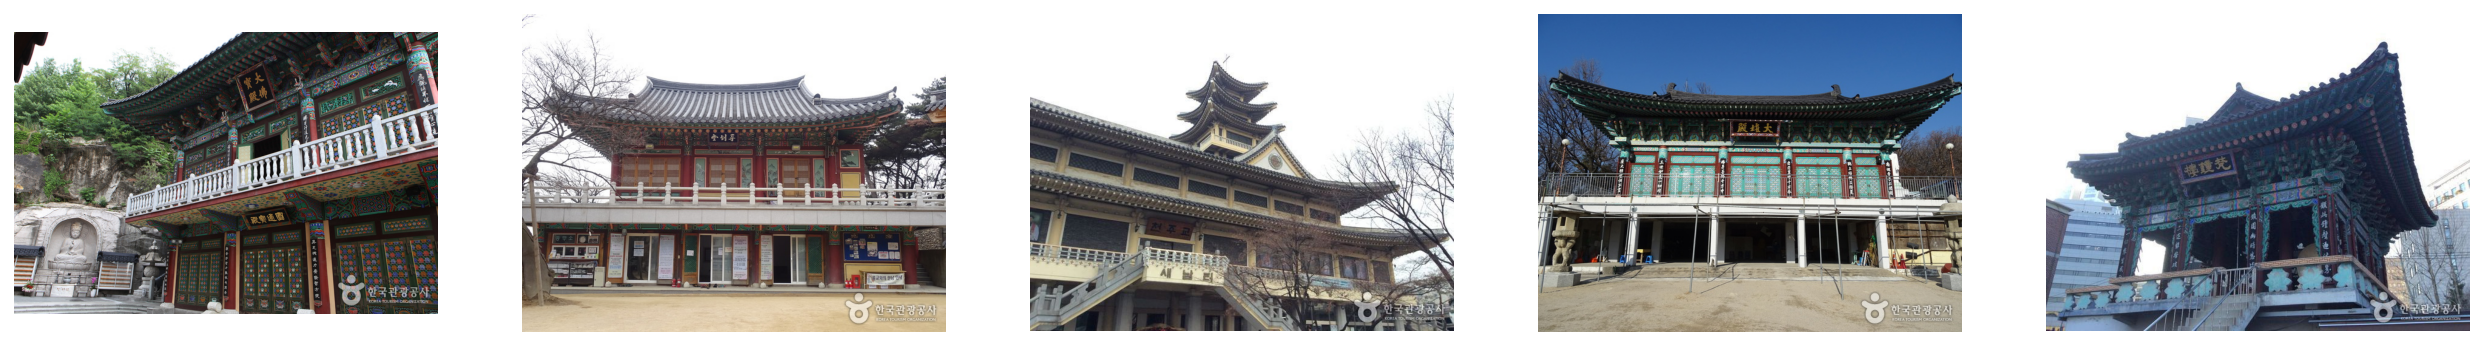

In [98]:
def show_result(names):
    main_dir = 'data/demo'
    figure, axs = plt.subplots(ncols=5, figsize=(22,15))
    
    
    for idx, name in enumerate(names):
        path = main_dir + '/' + name
        image = Image.open(path)
        axs[idx].imshow(image)
        axs[idx].axis('off')
        
show_result(recommend_list)